list of clusters by condition:
[0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2]


Scaling and centering input matrix.
Number of samples: 20
Number of features: 4
Cluster index of input data: 0.630701
Median absolute deviation from the median of input data: 0.855357
Estimated variance for background noise: 1.608167
Applying soft thresholding...
The 4 variances for simulation have
mean: 1.645470
standard deviation: 0.064611.
Simulating 1000 cluster indices.  Please wait...
Simulation complete.
The simulated cluster indices had
mean: 0.696593
standard deviation: 0.040180.
In 1000 iterations there were
59 cluster indices <= the cluster index 0.630701
of the input data.
p-value:  0.059000
The p value for
subcluster id / is 0.059000
Examining sub-clusters
/0 and /1
Computing RecClust data
for first cluster.
Please wait...
Scaling and centering input matrix.
Number of samples: 8
Number of features: 4
Cluster index of input data: 0.546144
Median absolute deviation from the median of input data: 0.777442
Estimated variance for background noise: 1.328532
Applying soft thresho

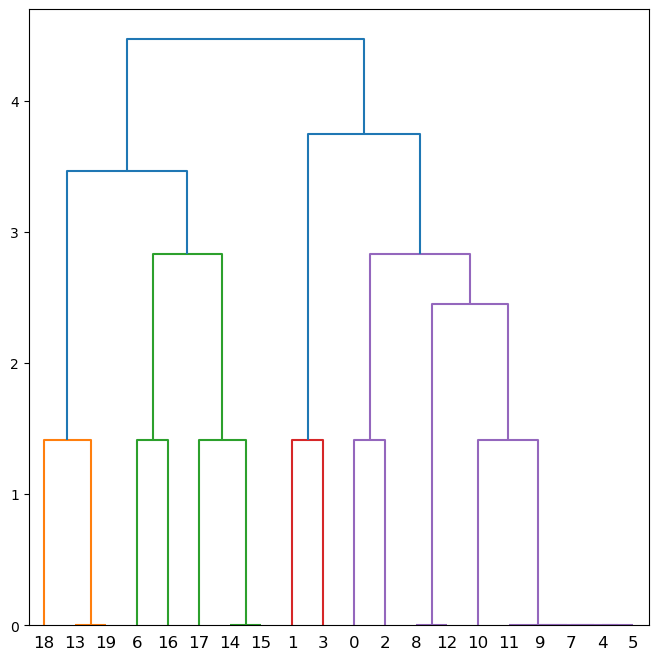

In [14]:
#Importing and data processing

import pandas as pd 
import numpy as np 
import plotly.express as px
import plotly.colors as pc
import umap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from sigclust.sigclust import sigclust
from sigclust.recclust import recclust

df = pd.read_csv("FinalCHActivation.csv") #reads in csv file
#(conditons (data points) = rows ; substrates (features) = columns)

my_array = df.values #converts dataframe to numpy array




# #Vector normalization (use for elimination and amination data - make sure this is commented if not using)
# normalized_array = preprocessing.normalize(my_array)




# #Vector normalization (use for phenol data - make sure this is commented if not using)
# Y = preprocessing.normalize(my_array)
# normalized_array = preprocessing.scale(Y)




#Ordinal normalization (Use for C–H activation - make sure this is commented if not using)
def normalize_array_by_ranking(arr):
    # Get the shape of the array
    rows, cols = arr.shape

    # Initialize a new array to store the normalized values and set it to NaN
    normalized_arr = np.full((rows, cols), np.nan)
    
    # Iterate through each row and replace non-NaN values with their rankings
    for i in range(rows):
        row = arr[i, :]
        non_nan_indices = np.logical_not(np.isnan(row))
        ranking = np.argsort(np.argsort(row[non_nan_indices]))
        normalized_arr[i, non_nan_indices] = ranking
    
    return normalized_arr

normalized_array = normalize_array_by_ranking(my_array)




# #Uncomment to save normalized data as CSV
# normalized_array_csv = pd.DataFrame(normalized_array, dtype = float)
# normalized_array_csv.to_csv("NormalizedYieldFingerprints.csv", sep='\t', index=False, encoding="utf-8")




# # Determine optimal number of clusters using the elbow method - use only if unsure of # clusters needed
# wcss = []
# max_clusters = 20
# for i in range(1, max_clusters + 1):
#     kmeans = KMeans(n_clusters=i, init='k-means++', random_state=13)
#     kmeans.fit(normalized_array)
#     wcss.append(kmeans.inertia_)

# plt.figure(figsize=(10, 6))
# plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='-', color='b')
# plt.title('Elbow Method for Optimal Number of Clusters')
# plt.xlabel('Number of Clusters')
# plt.ylabel('WCSS')
# plt.xticks(range(1, max_clusters + 1))
# plt.grid(True)
# plt.show()




#Clustering

#choose number of clusters
number_of_clusters = 3

#runs Lloyd's k means algorithm on data. Can change random state to other numbers to test significance quickly
KMeans = KMeans(n_clusters=number_of_clusters, init="k-means++", random_state=13)
clusters = KMeans.fit_predict(normalized_array)

colors = pc.qualitative.Plotly * (number_of_clusters // len(pc.qualitative.Plotly) + 1)
colors = colors[:number_of_clusters]
symbols = ['circle', 'square', 'diamond', 'cross', 'x', 'triangle-up', 'triangle-down', 'triangle-left', 'triangle-right', 'hexagram'] * (number_of_clusters // 10 + 1)
symbols = symbols[:number_of_clusters]
cluster_to_color_dictionary = {i: colors[i] for i in range(number_of_clusters)}
cluster_to_symbol_dictionary = {i: symbols[i] for i in range(number_of_clusters)}

#prints out results
print("list of clusters by condition:")
print(clusters)




#UMAP to visualize data points and clustering
#Make sure that only one reducer is active at once

# #UMAP reducer for Elimination (make sure this is commented if not using)
# reducer = umap.UMAP(
#     metric='cosine',
#     min_dist=1,
#     n_components=3,
#     n_neighbors=2,
#     random_state=42,
# )




# #UMAP reducer for Phenols (uncomment if not using)
# reducer = umap.UMAP(
#     metric='cosine',
#     min_dist=1,
#     n_components=2,
#     n_neighbors=10,
#     random_state=42,
# )




#UMAP reducer for CH activation (make sure this is commented if not using)
reducer = umap.UMAP(
    metric='cosine',
    min_dist=0.6,
    n_components=3,
    n_neighbors=3,
    random_state=42,
)




# #UMAP reducer for Amination (uncomment if not using)
# reducer = umap.UMAP(
#     metric='cosine',
#     min_dist=0.1,
#     n_components=2,
#     n_neighbors=3,
#     random_state=42,
# )




#Plot dimensional reduction
reducer.fit(normalized_array)
embedding = reducer.transform(normalized_array)
assert(np.all(embedding == reducer.embedding_))
fig3 = px.scatter(embedding, x=0, y=1, color=[cluster_to_color_dictionary[label] for label in clusters], symbol=[cluster_to_symbol_dictionary[label] for label in clusters], width=1000, height=500)
for i, entry_number in enumerate(range(len(normalized_array))):
    fig3.add_annotation(x=embedding[i, 0], y=embedding[i, 1], text=str(entry_number), showarrow=False, font=dict(color="white", size=11))
fig3.update_traces(marker_size=14)
fig3.show()




#Check for cluster significance using sigclust
recclust(normalized_array, threshold=0.10, mc_iters=1000)

#Visualize sigclust
B = hierarchy.linkage(normalized_array, 'complete')
plt.figure(figsize=[8, 8])
dn = hierarchy.dendrogram(B)